In [2]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

5.1 Approximate state-value functions for the blackjack policy that sticks only on 20 or 21, computed by Monte Carlo policy evaluation.

In [ ]:
#Dealer's shown card ranges from 1 to 10
sd = 10 
#Sum of player's cards' can be 12 to 21
sum_ps = 10

#Bust criteria
bust = 21 
#Stick (Not taking new card) Criteria
player_stick = 20
dealer_stick = 17

#0 means usable Ace, and 1 is Not usable ace
#0 means hit for player; 1 -> hit for dealer
#Usable and no usable Ace
n_ace = 2 
#Hit for dealer and player, as stick for player is hit for dealer and stick for dealer is termination
action = 2 

#total types of cards are - 2-10, J, Q, K (10) so probability of getting 10 is 4/13
n_c = 10 

#probabilities of different cards
p = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 4])/13

#mapping for possible Player's sum
ps_map = 12

#State is defined by (player sum, dealer card, usability of ace)
# Thus, the player makes decisions on the basis of three variables: his current sum
# (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable
# ace. This makes for a total of 200 states (10*10*2)

#mapping for dealer possible sum
d_map = 1

V = np.zeros((sum_ps+1, sd+1, n_ace)) #intializing state values as zero , +1 for intial state
print(V.shape) #11*11*2
Count = np.zeros((sum_ps, sd, n_ace)) 

(11, 11, 2)


In [ ]:
def reward(ps, d, ace, d_ace, act):
    ps1, d1, ace1, d_ace1, r = ps, d, ace, d_ace, 0
    
    if act == 1:
        #Next card
        card = np.random.choice(n_c, p=p) + 1
        d1 += card

        if d1 + d_map > dealer_stick:
            #draw
            if d1 + d_map == ps1 + ps_map:
                r = 0 #draw
            #win on dealer bust
            if d1 + d_map > bust:
                r = 1 #win
            else :
                r = np.sign((ps1+ps_map) - (d1+d_map))
        
        elif d1 + d_map > bust:
            if d_ace:
                d1 -= 10
                d_ace1 = False
            else:
                d1 = (bust - d_map) + 1       
    
    if act == 0:
        card = np.random.choice(n_c, p=p) + 1
        ps1 += card
        if ps1 + ps_map > bust:
            if ace == 0:
                ps1 -= 10
                ace1 = 1
            #Bust
            else:
                ps1 = (bust - ps_map) + 1
                r = -1 #loss
                
    return ps1, d1, ace1, d_ace1, r

In [ ]:
def gen_eps(ps, d, ace):
    terminate = True
    eps = []
    d_ace = d == 0
    ds = d + 10
    while terminate:
        ep = [[ps, d, ds, ace]]
        #Player hits, dealer won't get a chance
        if ps + ps_map < player_stick:
            act = 0
            ep.append(act)
            ps, ds, ace, d_ace, rwd = reward(ps, ds, ace, d_ace, act) #reward
            ep.append(rwd)
            eps.append(ep)
        #Player sticks, player can bust or dealer hits
        else:
            #Dealer hits
            if ds + d_map < dealer_stick:
                act = 1 
                ep.append(act)
                ps, ds, ace, d_ace, rwd = reward(ps, ds, ace, d_ace, act) #reward
                ep.append(rwd)
                eps.append(ep)
            #Player Bust
            elif ps + ps_map > bust:
                terminate = False
            #Dealer Sticks
            else:
                terminate = False
    return eps

In [ ]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits

n_eps = 500000 #number of episode
ter_eps = 9999 #termination of episode
V_ter_eps = 0 #reinializatiling state values 

for e in tqdm(range(n_eps)):
    #Randomly generating the value of sum of player, sum of dealer, and usuability of ace
    ps, d, ace = np.random.randint(sum_ps), np.random.randint(sd), np.random.randint(n_ace)
    #Generating Episode
    eps = gen_eps(ps, d, ace)
    T = len(eps) #length of episode
    #print(T)
    G = 0 #initializing return
    for t in range(T-1, -1, -1):
        (ps, d, ds, ace), a, r = eps[t]
        if ps + ps_map > bust:
            continue
        V[ps, d, ace] += (G - V[ps, d, ace])/(Count[ps, d, ace] + 1) #updating state value
        G += r #adding reward to G
        Count[ps, d, ace] += 1
    
    if e == ter_eps:
        V_ter_eps = np.copy(V) #saving the final state value for terminal state

100%|██████████| 500000/500000 [00:44<00:00, 11170.36it/s]


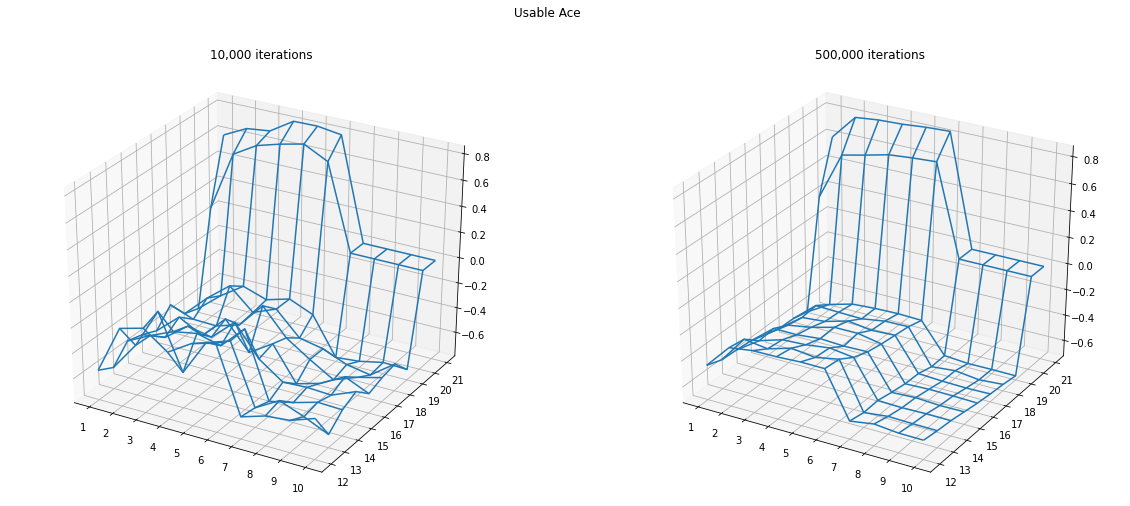

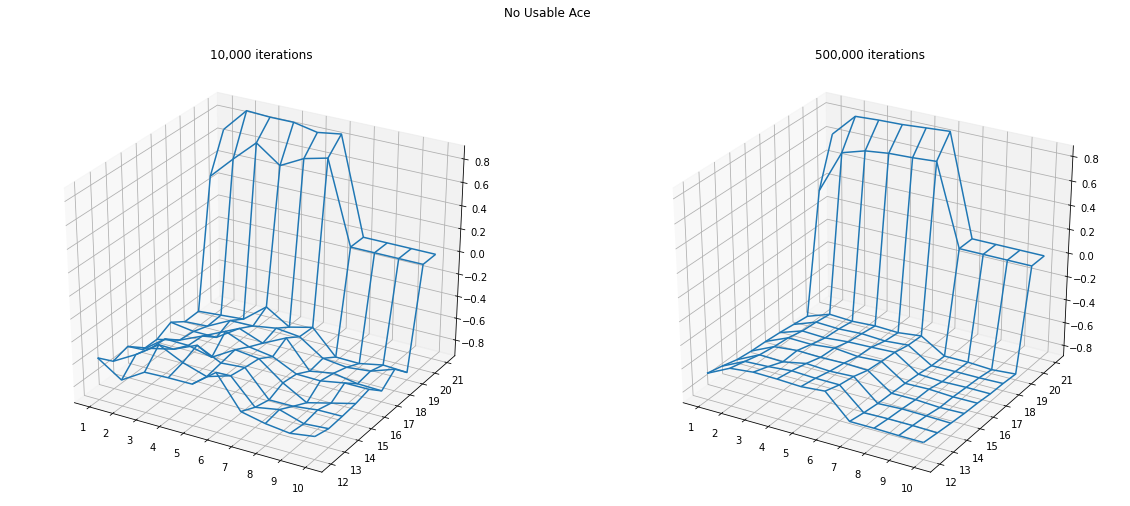

In [ ]:
xv, yv = np.meshgrid(np.arange(10)+12, np.arange(10)+1, indexing='ij') #players sum + mapping, dealers sum + mapping

fig = plt.figure(figsize=(20, 8))
fig.suptitle('Usable Ace')

ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(yv, xv, V_ter_eps[:-1, :-1, 0]) #players sum + mapping, dealers sum + mapping, terminal state value
plt.xticks(np.arange(10)+d_map)
plt.yticks(np.arange(10)+ps_map)
ax.title.set_text('10,000 iterations')

ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(yv, xv, V[:-1, :-1, 0]) #players sum + mapping, dealers sum + mapping, state value
plt.xticks(np.arange(10)+d_map)
plt.yticks(np.arange(10)+ps_map)
ax.title.set_text('500,000 iterations')

fig = plt.figure(figsize=(20, 8))
fig.suptitle('No Usable Ace')
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(yv, xv, V_ter_eps[:-1, :-1, 1])
plt.xticks(np.arange(10)+d_map)
plt.yticks(np.arange(10)+ps_map)
ax.title.set_text('10,000 iterations')

ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(yv, xv, V[:-1, :-1, 1])
plt.xticks(np.arange(10)+d_map)
plt.yticks(np.arange(10)+ps_map)
ax.title.set_text('500,000 iterations')

New policy -  In this case one simply picks the dealer’s cards, the
player’s sum, and whether or not the player has a usable ace, all at random with equal
probability for figure 5.2

In [ ]:
n_eps = 500000

policy = np.zeros((sum_ps, sd, n_ace))

Q = np.zeros((sum_ps+1, sd+1, n_ace, action))
Count_Q = np.zeros((sum_ps, sd, n_ace, action)) 

V = np.zeros((sum_ps+1, sd+1, n_ace))
Count_V = np.zeros((sum_ps, sd, n_ace)) 


for e in tqdm(range(n_eps)):
    #Random starting point selection
    ps, d, ace, a = np.random.randint(sum_ps), np.random.randint(sd), np.random.randint(n_ace), np.random.randint(action)
    eps = gen_eps(ps, d, ace)
    T = len(eps)
    G = 0
    for t in range(T-1, -1, -1):
        (ps, d, ds, ace), a, r = eps[t]
        if ps + ps_map > bust:
            continue
        G += r
        Q[ps, d, ace, a] += (G - Q[ps, d, ace, a])/(Count_Q[ps, d, ace, a] + 1) #Q value 
        Count_Q[ps, d, ace, a] += 1
        V[ps, d, ace] += (G - V[ps, d, ace])/(Count_V[ps, d, ace] + 1) #state
        Count_V[ps, d, ace] += 1
        policy[ps, d, ace] = np.argmax(Q[ps, d, ace])#policy improvement

100%|██████████| 500000/500000 [00:57<00:00, 8766.10it/s]


([<matplotlib.axis.XTick at 0x7f4652680810>,
 <a list of 10 Text major ticklabel objects>)

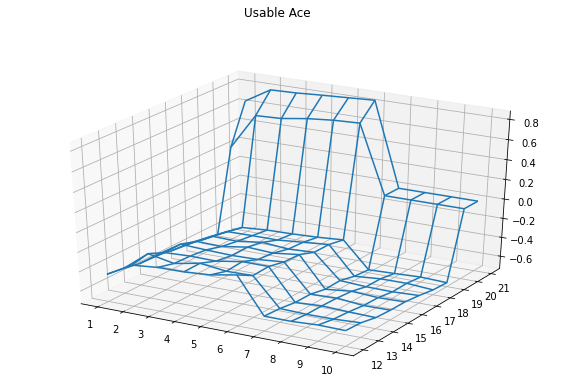

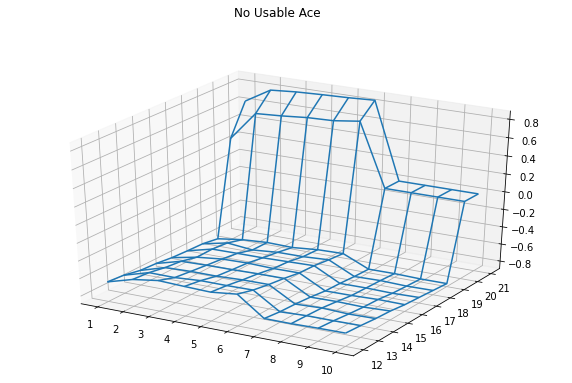

In [ ]:
xv, yv = np.meshgrid(np.arange(10)+12, np.arange(10)+1, indexing='ij')

fig = plt.figure(figsize=(10, 6))
fig.suptitle('Usable Ace')
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(yv, xv, V[:-1, :-1, 0])
plt.xticks(np.arange(10)+d_map)
plt.yticks(np.arange(10)+ps_map)

fig = plt.figure(figsize=(10, 6))
fig.suptitle('No Usable Ace')
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(yv, xv, V[:-1, :-1, 1])
plt.xticks(np.arange(10)+d_map)
plt.yticks(np.arange(10)+ps_map)

Figure 5.3: Weighted importance sampling produces lower error estimates of the value of a
single blackjack state from o↵-policy episodes.

In [3]:
# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E

values = np.zeros(7)
values[1:6] = 0.5
values

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. ])

In [4]:
values[6] = 1 #the right terminal state has value 1

In [5]:
values

array([0. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. ])

In [6]:
# true values of all the states
true_value = np.zeros(7)
true_value[1:6] = np.arange(1, 6) / 6.0
true_value[6] = 1
true_value

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [7]:
# action
left = 0
right = 1

In [18]:
def rms_error():
    episodes = 100 + 1
    runs = 100
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    td_alphas = [0.15, 0.1, 0.05]
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        for r in tqdm(range(runs)):
            errors = []
            current_values = np.copy(values)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(true_value - current_values, 2)) / 5.0))
                if method == 'TD':
                    td(current_values, alpha=alpha)
                else:
                    mc(current_values, alpha=alpha)
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', alpha = %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()


In [14]:
def td(values, alpha=0.1, batch=False):
    state = 3
    episodes = [state]
    rewards = [0]
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == left:
            state -= 1
        else:
            state += 1
        reward = 0
        episodes.append(state)
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return episodes , rewards

In [15]:
def mc(values, alpha=0.1, batch=False):
    state = 3
    episodes= [3]

    while True:
        if np.random.binomial(1, 0.5) == left:
            state -= 1
        else:
            state += 1
        episodes.append(state)
        if state == 0:
            returns = 0.0
            break
        elif state == 6:
            returns = 1.0
            break
    if not batch:
        for state_ in episodes[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])
    return episodes, [returns] * (len(episodes) - 1)

In [10]:
def state_value():
    episodes = [0, 1, 10, 100]
    current_values = np.copy(values)
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(current_values, label=str(i) + ' episodes')
        td(current_values)
    plt.plot(true_value, label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()

100%|██████████| 100/100 [00:00<00:00, 155.71it/s]


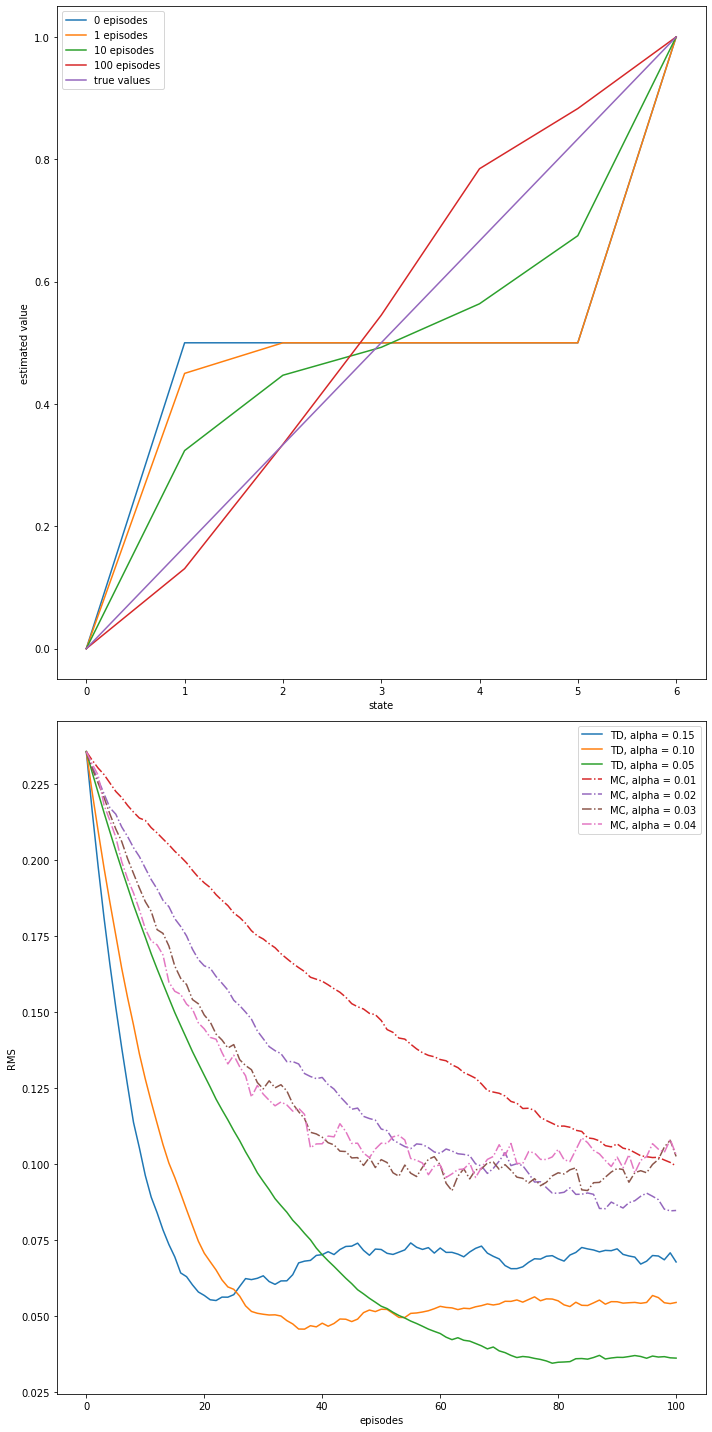

In [19]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
state_value()

plt.subplot(2, 1, 2)
rms_error()
plt.tight_layout()

In [27]:
def batch(method, episodes, alpha=0.001):
    # perform 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(values)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'MC':
                trajectory_, rewards_ = mc(current_values, batch=True)
            else:
                trajectory_, rewards_ = td(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'MC':
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - true_value, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


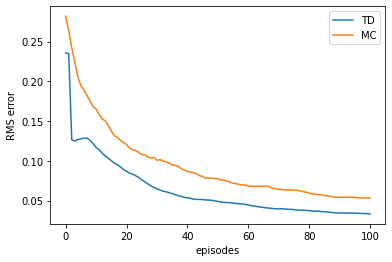

In [28]:
episodes = 100 + 1
td_erros = batch('TD', episodes)
mc_erros = batch('MC', episodes)

plt.plot(td_erros, label='TD')
plt.plot(mc_erros, label='MC')
plt.xlabel('episodes')
plt.ylabel('RMS error')
plt.legend()